In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import csv 
import edgar
import os
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

Get CIK list of all investment companies

In [2]:
df_MF = pd.read_csv(r'https://goz39a.s3.eu-central-1.amazonaws.com/13F/CIK_list.csv')
df_MF['Entity Name'] = df_MF['Entity Name']
#[i.find(isin(t)) for i in df_MF.loc[df_MF['Entity Name']]]
df_MF

,Unnamed: 0,CIK Number,Entity Name,Address_1,City,State,Zip Code
0,0,2110,COLUMBIA ACORN TRUST,227 W MONROE STE 3000,CHICAGO,IL,60606
1,1,2646,Voya INTERMEDIATE BOND PORTFOLIO,ING FUNDS SERVICES,SCOTTSDALE,AZ,85258
2,2,2663,VOYA GOVERNMENT MONEY MARKET PORTFOLIO,"7337 E. DOUBLETREE RANCH ROAD, STE 100",SCOTTSDALE,AZ,85258
3,3,2664,Voya VARIABLE FUNDS,"7337 E. DOUBLETREE RANCH ROAD, STE 100",SCOTTSDALE,AZ,85258
4,4,2691,LORD ABBETT AFFILIATED FUND INC,90 HUDSON STREET,JERSEY CITY,NJ,07302
...,...,...,...,...,...,...,...
2146,2146,1810747,Simplify Exchange Traded Funds,154 W 14TH ST,NEW YORK,NY,10011
2147,2147,1811168,2nd Vote Funds,PO BOX 2916,HENDERSONVILLE,TN,37077
2148,2148,1815558,Waycross Independent Trust,"C/O ULTIMUS FUND SOLUTIONS, LLC",CINCINNATI,OH,45246
2149,2149,1815608,Modern Capital Funds Trust,1050 JOHNNIE DODDS BLVD,MT. PLEASANT,SC,29465


download all filings from 2020-2021

In [3]:
path= r'c:/Users/ASUS/Desktop/filing_history'
edgar.download_index(path, 2020, skip_all_present_except_last=False)

select the URL to the edgar archive for the 13F-HR filings of 2020 until q1 of 2021

In [4]:
def get_urls(path_download_index):
    with open(path_download_index,'r') as file:
        tsvreader = csv.reader(file, delimiter="|")
        urls= []
        file = []
        for line in tsvreader:
            if line[1:][1] == '13F-HR':
                adress=line[-1]
                url =  'https://www.sec.gov/Archives/' + adress
                holding = line[1]
                urls.append((holding.lower(), url))
    return urls

In [5]:
path= r'c:/Users/ASUS/Desktop/filing_history'

urls_2020_1 = get_urls(path + os.sep + '2020-QTR1.tsv')
urls_2020_2 = get_urls(path + os.sep + '2020-QTR2.tsv')
urls_2020_3 = get_urls(path + os.sep + '2020-QTR3.tsv')
urls_2020_4 = get_urls(path + os.sep + '2020-QTR4.tsv')
urls_2021 = get_urls(path + os.sep + '2021-QTR1.tsv')

Select only investment companies with 13F-HR filings in all quarters

In [6]:
urls_2020_1names, _ = zip(*urls_2020_1)
urls_2020_2names, _ = zip(*urls_2020_2)
urls_2020_3names, _ = zip(*urls_2020_3)
urls_2020_4names, _ = zip(*urls_2020_4)
urls_2021_names, _ =zip(*urls_2021)

companiesBoth = [i for i in (urls_2020_1names and urls_2020_2names and urls_2020_3names and urls_2020_4names and urls_2021_names  )]


In [7]:
len(companiesBoth)

5970

List of biggest investment companies from https://mutualfunddirectory.org/latest-directory-ranking-here/

In [8]:
URL = 'https://mutualfunddirectory.org/latest-directory-ranking-here/'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')
table = soup.find('table', class_="tablepress-id-109")
for company in table.find_all('tbody'):
    rows= company.find_all('tr')
    companies =[]
    for row in rows:
        companies.append(row.find('td', class_="column-2").text)

companies = companies[:-1]
companies = [i.lower() for i in companies]

From companies with filings in each quarter, only select biggest companies

In [10]:
urls_list=[]
period = [urls_2020_1, urls_2020_2, urls_2020_3, urls_2020_4, urls_2021]
for quarter in period:
    urls = []
    companies_quarter = [i for i in quarter if i[0] in companiesBoth]
    for company_quarter in companies_quarter:
        if len(company_quarter[0].split())>1:
            if company_quarter[0].split()[0] in companies or company_quarter[0].split()[1] in companies:
                urls.append(company_quarter[1])
        else:
             if company_quarter[0].split()[0] in companies:
                urls.append(company_quarter[1])
    urls_list.append(urls)

In [11]:
unique_companies=[urls_list[1][j].split('data/')[1].split('/')[0] for j in range(len(urls_list[1]))]
unique_urls_list=[]
for i in range(len(urls_list)):
    unique_urls=[urls_list[i][j] for j in range(len(urls_list[i])) if urls_list[i][j].split('data/')[1].split('/')[0] in unique_companies]
    unique_urls_list.append(unique_urls)

In [12]:
[print('number of filings: %s'%len(set(unique_urls_list[i]))) for i in range(len(unique_urls_list))]

number of filings: 20
number of filings: 20
number of filings: 20
number of filings: 20
number of filings: 20


[None, None, None, None, None]

In [13]:
def parser(urls):
    '''Returns dataframe of all the securities of all filings by concatenating the filing tables found at Edgar Archives'''
    df = []
    for url in urls:
        my_header = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36'
,
                'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
                'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
                'Accept-Encoding': 'none',
                'Accept-Language': 'en-US,en;q=0.8',
                'Connection': 'keep-alive'}
        #url = 'https://www.sec.gov/Archives/edgar/data/1000742/0001567619-20-003961-index.html'
        page = requests.get(url,  headers=my_header)    
        data = page.text
        soup = BeautifulSoup(data, "lxml")
        result= soup.find_all('div', attrs={'class':'formGrouping'})[0]
        date = result.find('div',attrs={'class':'info'}).text
        index = soup.find('div',{'id':'secNum'}).text.replace('SEC Accession No. ','').replace('\n','')
        entityName = soup.find('span',attrs={'class':"companyName"}).text 
        entityName = entityName.partition("(Filer)")[0]

        #get third hyperlink on page which directs to info table
        table_link = soup.find('table',attrs={'class':'tableFile'})
        table_link = table_link.find_all('a')
        table_link = table_link[2]
        identifier=table_link.get('href')
        url = 'https://www.sec.gov'+identifier
        
        #get CIK number from URL
        cik_company = url.split('data/')[1].split('/')[0]
        
        #parse html table to dataframe
        ## retry when 'https forbidden' error is raised, until page can be scraped successfully 
        DF_13F = None
        while DF_13F is None:
            try:
                DF_13F = pd.read_html(url)
                DF_13F = DF_13F[-1]
                DF_13F = DF_13F.iloc[2:]
                new_header = DF_13F.iloc[0]
                DF_13F.columns = new_header
                DF_13F = DF_13F.iloc[2:]
                DF_13F['date_reported'] = date
                DF_13F['CIK'] = cik_company
                DF_13F['filing index'] = index
                DF_13F['Entity name'] = entityName

                # Get entity name from CIK code from list of all funds
                #DF_13F['Entity Name'] = df_MF['Entity Name'].loc[df_MF['CIK Number'] == cik_company].values
                DF_13F = DF_13F[['filing index','date_reported','NAME OF ISSUER','TITLE OF CLASS','CUSIP','(x$1000)','PRN AMT','PRN','CIK','Entity name']]
                df.append(DF_13F)
                print('Filing found for cik %s at %s' %(cik_company,url))

            except:
                print('Retry, could not parse cik %s at: %s'%(cik_company,url))
                pass
    return pd.concat(df)

In [14]:
df_All = {'quarter_' +str(i) : parser(unique_urls_list[i]) for i in range(4) }

Filing found for cik 1027796 at https://www.sec.gov/Archives/edgar/data/1027796/000156761920002400/xslForm13F_X01/form13fInfoTable.xml
Retry, could not parse cik 102909 at: https://www.sec.gov/Archives/edgar/data/102909/000110465920020869/xslForm13F_X01/infotable.xml
Retry, could not parse cik 102909 at: https://www.sec.gov/Archives/edgar/data/102909/000110465920020869/xslForm13F_X01/infotable.xml
Retry, could not parse cik 102909 at: https://www.sec.gov/Archives/edgar/data/102909/000110465920020869/xslForm13F_X01/infotable.xml
Filing found for cik 102909 at https://www.sec.gov/Archives/edgar/data/102909/000110465920020869/xslForm13F_X01/infotable.xml
Filing found for cik 1109448 at https://www.sec.gov/Archives/edgar/data/1109448/000153215520000112/xslForm13F_X01/ACMLInfoTable.xml
Filing found for cik 1123274 at https://www.sec.gov/Archives/edgar/data/1123274/000159957620000002/xslForm13F_X01/US13F_PCO_EUR_2019_Q4.xml
Retry, could not parse cik 1132716 at: https://www.sec.gov/Archives/

Filing found for cik 1535602 at https://www.sec.gov/Archives/edgar/data/1535602/000153560220000004/xslForm13F_X01/US13F_BPSA_2020_Q2.xml
Filing found for cik 1535631 at https://www.sec.gov/Archives/edgar/data/1535631/000153563120000005/xslForm13F_X01/US13F_PBT_2020_Q2.xml
Filing found for cik 1599469 at https://www.sec.gov/Archives/edgar/data/1599469/000159946920000005/xslForm13F_X01/US13F_BPCAL_2020_Q2.xml
Filing found for cik 1599576 at https://www.sec.gov/Archives/edgar/data/1599576/000159957620000004/xslForm13F_X01/US13F_PNAA_2020_Q2.xml
Filing found for cik 1610520 at https://www.sec.gov/Archives/edgar/data/1610520/000095012320007389/xslForm13F_X01/735.xml
Filing found for cik 801051 at https://www.sec.gov/Archives/edgar/data/801051/000108514620002049/xslForm13F_X01/infotable.xml
Retry, could not parse cik 861177 at: https://www.sec.gov/Archives/edgar/data/861177/000086117720000007/xslForm13F_X01/Information_Table.xml
Filing found for cik 861177 at https://www.sec.gov/Archives/edg

In [15]:
# save dataframe object as pickle to use in other notebooks
with open("C:/Users/ASUS/Desktop/df_All","wb") as f:
    pickle.dump(df_All, f)
f.close()

In [3]:

df=pickle.load(open('C:/Users/ASUS/Desktop/df_All',"rb"))

In [17]:
df_All

{'quarter_0': 2                  filing index date_reported          NAME OF ISSUER  \
 4    0001567619-20-002400          2020-02-07         ACTUANT CORP- A   
 5    0001567619-20-002400          2020-02-07                   AECOM   
 6    0001567619-20-002400          2020-02-07                AES CORP   
 7    0001567619-20-002400          2020-02-07           ALLSTATE CORP   
 8    0001567619-20-002400          2020-02-07              AMDOCS LTD   
 ..                          ...           ...                     ...   
 190  0000949509-20-000002          2020-02-14    WESTERN DIGITAL CORP   
 191  0000949509-20-000002          2020-02-14  WHITING PETROLEUM CORP   
 192  0000949509-20-000002          2020-02-14       YETI HOLDINGS INC   
 193  0000949509-20-000002          2020-02-14                  YPF SA   
 194  0000949509-20-000002          2020-02-14        ZILLOW GROUP INC   
 
 2      TITLE OF CLASS      CUSIP (x$1000)   PRN AMT  PRN      CIK  \
 4                 COM  005

In [18]:
# select first quarter 2020
df = df['quarter_0']

In [19]:
df

2,filing index,date_reported,NAME OF ISSUER,TITLE OF CLASS,CUSIP,(x$1000),PRN AMT,PRN,CIK,Entity name
4,0001567619-20-002400,2020-02-07,ACTUANT CORP- A,COM,00508X203,103856,3989841,SH,1027796,PZENA INVESTMENT MANAGEMENT LLC
5,0001567619-20-002400,2020-02-07,AECOM,COM,00766T100,113169,2623898,SH,1027796,PZENA INVESTMENT MANAGEMENT LLC
6,0001567619-20-002400,2020-02-07,AES CORP,COM,00130H105,909,45692,SH,1027796,PZENA INVESTMENT MANAGEMENT LLC
7,0001567619-20-002400,2020-02-07,ALLSTATE CORP,COM,020002101,31883,283530,SH,1027796,PZENA INVESTMENT MANAGEMENT LLC
8,0001567619-20-002400,2020-02-07,AMDOCS LTD,COM,G02602103,949,13152,SH,1027796,PZENA INVESTMENT MANAGEMENT LLC
...,...,...,...,...,...,...,...,...,...,...
190,0000949509-20-000002,2020-02-14,WESTERN DIGITAL CORP,CONVERTIBLE BOND,958102AP0,8875,9016000,PRN,949509,OAKTREE CAPITAL MANAGEMENT LP
191,0000949509-20-000002,2020-02-14,WHITING PETROLEUM CORP,CONVERTIBLE BOND,966387AL6,5954,6069000,PRN,949509,OAKTREE CAPITAL MANAGEMENT LP
192,0000949509-20-000002,2020-02-14,YETI HOLDINGS INC,COMMON STOCK,98585X104,14533,417866,SH,949509,OAKTREE CAPITAL MANAGEMENT LP
193,0000949509-20-000002,2020-02-14,YPF SA,COMMON STOCK,984245100,15709,1356600,SH,949509,OAKTREE CAPITAL MANAGEMENT LP


In [32]:
# entity names as labels
labels = list(set(df['Entity name'].str.lower()))

In [21]:
labels

['invesco senior secured management inc /adv ',
 'pictet bank & trust ltd ',
 'banque pictet & cie sa ',
 'metlife investment management, llc ',
 'ubs oconnor llc ',
 'pzena investment management llc ',
 'invesco ltd. ',
 'aegon usa investment management, llc ',
 'ubs group ag ',
 'barings llc ',
 'pictet & cie (europe) sa ',
 'vanguard group inc ',
 'conning inc. ',
 'transamerica financial advisors, inc. ',
 'alliancebernstein l.p. ',
 'pictet north america advisors sa ',
 'ubs asset management americas inc ',
 'bank pictet & cie (asia) ltd ',
 'pictet asset management ltd ',
 'oaktree capital management lp ']

In [6]:
def Adj_weight(df):
    dummies = pd.get_dummies(df['CUSIP']).astype(float)
    weights=dummies.T*np.asarray(df['(x$1000)']).astype(float)
    df_ = pd.concat([df[['CIK']],weights.T],axis=1)
    weights = df_.groupby(['CIK']).sum()
    v=np.dot(weights,weights.T)
    v=np.tril(v,0)
    return v

In [24]:
adj = Adj_weight(df)

In [25]:
adj.shape

(20, 20)

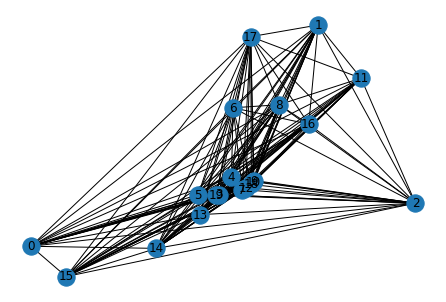

In [27]:
np.random.seed(3)
G = nx.from_numpy_matrix(adj)
labels={i: labels[i] for i in G.nodes}
#G=nx.relabel_nodes(G, labels)
pos= nx.draw_spring(G,with_labels=True)

plt.axis("off")
plt.show()

In [28]:
bb = nx.betweenness_centrality(G)
cc = nx.closeness_centrality(G)
dc = nx.degree_centrality(G)
centrality = {j:{'betweenness':bb[j],'closeness': cc[j],'degree': dc[j]} for i,j in enumerate(G.nodes)}
nx.set_node_attributes(G, centrality)



dict(sorted(bb.items(), key=lambda item: -item[1]))

{1: 0.0061544635848041415,
 2: 0.0061544635848041415,
 4: 0.0061544635848041415,
 5: 0.0061544635848041415,
 8: 0.0061544635848041415,
 13: 0.0061544635848041415,
 14: 0.0061544635848041415,
 15: 0.0061544635848041415,
 17: 0.0061544635848041415,
 18: 0.0061544635848041415,
 19: 0.005323136902084271,
 0: 0.0032679738562091496,
 7: 0.0028864897285949915,
 6: 0.0008313266827198715,
 16: 0.000449842555105713,
 3: 0.0003439972480220158,
 9: 0.0003439972480220158,
 10: 0.0003439972480220158,
 11: 0.0003439972480220158,
 12: 0.0003439972480220158}

In [29]:
summary=pd.DataFrame({'betweenness':bb, 'closeness':cc, 'degree':dc}).reset_index()

In [34]:
summary['index']=labels

In [35]:
summary

,index,betweenness,closeness,degree
0,invesco senior secured management inc /adv,0.003268,0.950000,1.052632
1,pictet bank & trust ltd,0.006154,1.000000,1.105263
2,banque pictet & cie sa,0.006154,1.000000,1.105263
3,"metlife investment management, llc",0.000344,0.904762,1.000000
4,ubs oconnor llc,0.006154,1.000000,1.105263
5,pzena investment management llc,0.006154,1.000000,1.105263
6,invesco ltd.,0.000831,0.760000,0.789474
7,"aegon usa investment management, llc",0.002886,0.904762,1.000000
8,ubs group ag,0.006154,1.000000,1.105263
9,barings llc,0.000344,0.904762,1.000000


community detection

In [36]:
#Label propagation algorithm
from networkx.algorithms.community.label_propagation import label_propagation_communities
I=list(label_propagation_communities(G))
#no parameters to tune
I #no communities detected?

[{0},
 {1},
 {2},
 {3},
 {4},
 {5},
 {6},
 {7},
 {8},
 {9},
 {10},
 {11},
 {12},
 {13},
 {14},
 {15},
 {16},
 {17},
 {18},
 {19}]

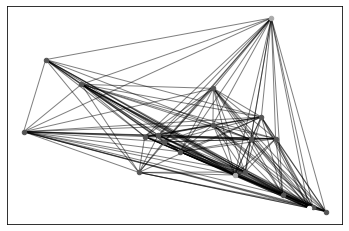

In [37]:
import community
#louvain method if i understand correctly #from this website https://perso.crans.org/aynaud/communities/
#first compute the best partition
partition = community.best_partition(G)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(G,pos, alpha=0.5)
plt.show()

In [38]:
#another algorithm for community detection
def edge_to_remove(graph):
    G_dict=nx.edge_betweenness_centrality(graph)
    edge=()
    
    #extract the edge with the highest edge betweenness centrality score
    for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse=True):
        edge=key
        break
    return edge
def girvan_newman(graph):
	# find number of connected components
	sg = nx.connected_components(graph)
	sg_count = nx.number_connected_components(graph)

	while(sg_count == 1):
		graph.remove_edge(edge_to_remove(graph)[0], edge_to_remove(graph)[1])
		sg = nx.connected_components(graph)
		sg_count = nx.number_connected_components(graph)

	return sg

In [39]:
#find communities in the graph
c=girvan_newman(G.copy())
#find the nodes forming the communities
node_groups=[]

for i in c:
    node_groups.append(list(i))

In [40]:
node_groups

[[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [6]]

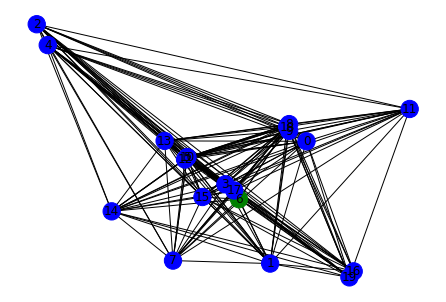

In [41]:
# plot the communities
color_map = []
for node in G:
    if node in node_groups[0]:
        color_map.append('blue')
    else: 
        color_map.append('green')  

nx.draw(G, node_color=color_map, with_labels=True)
plt.show()

In [42]:
nx.all_pairs_node_connectivity(G)
#no parameters to tune

{0: {1: 18,
  2: 18,
  3: 17,
  4: 18,
  5: 18,
  6: 13,
  7: 17,
  8: 18,
  9: 17,
  10: 17,
  11: 17,
  12: 17,
  13: 18,
  14: 18,
  15: 18,
  16: 13,
  17: 18,
  18: 18,
  19: 18},
 1: {0: 18,
  2: 19,
  3: 17,
  4: 19,
  5: 19,
  6: 13,
  7: 17,
  8: 19,
  9: 17,
  10: 17,
  11: 17,
  12: 17,
  13: 19,
  14: 19,
  15: 19,
  16: 13,
  17: 19,
  18: 19,
  19: 18},
 2: {0: 18,
  1: 19,
  3: 17,
  4: 19,
  5: 19,
  6: 13,
  7: 17,
  8: 19,
  9: 17,
  10: 17,
  11: 17,
  12: 17,
  13: 19,
  14: 19,
  15: 19,
  16: 13,
  17: 19,
  18: 19,
  19: 18},
 3: {0: 17,
  1: 17,
  2: 17,
  4: 17,
  5: 17,
  6: 13,
  7: 17,
  8: 17,
  9: 17,
  10: 17,
  11: 17,
  12: 17,
  13: 17,
  14: 17,
  15: 17,
  16: 13,
  17: 17,
  18: 17,
  19: 17},
 4: {0: 18,
  1: 19,
  2: 19,
  3: 17,
  5: 19,
  6: 13,
  7: 17,
  8: 19,
  9: 17,
  10: 17,
  11: 17,
  12: 17,
  13: 19,
  14: 19,
  15: 19,
  16: 13,
  17: 19,
  18: 19,
  19: 18},
 5: {0: 18,
  1: 19,
  2: 19,
  3: 17,
  4: 19,
  6: 13,
  7: 17,
  8: 19,


In [43]:
nx.node_connectivity(G) #equal to the minimum number of nodes that must be removed to disconnect G or render it trivial
#no parameters to tune

13

In [44]:
nx.degree_assortativity_coefficient(G) #measures the similarity of connections in the graph wrt the nodes 
#maybe we can use the weight parameters

-0.08001323768046001

In [45]:
nx.communicability_betweenness_centrality(G)
#no parameters to tune

{0: 0.6001793772525654,
 1: 0.6317385286872984,
 2: 0.6317385286872984,
 3: 0.5675916523640425,
 4: 0.6317385286872984,
 5: 0.6317385286872984,
 6: 0.3768517023314684,
 7: 0.5577488641820079,
 8: 0.6317385286872976,
 9: 0.5675916523640424,
 10: 0.5675916523640423,
 11: 0.5675916523640423,
 12: 0.5675916523640424,
 13: 0.6317385286872981,
 14: 0.631738528687298,
 15: 0.6317385286872981,
 16: 0.3789446417666582,
 17: 0.631738528687298,
 18: 0.6317385286872979,
 19: 0.5921373768822514}

In [46]:
nx.voterank(G) 
#no parameters to tune

[1, 2, 4, 5, 8, 13, 14, 15, 17, 18, 0, 19]

In [47]:
nx.clustering(G)
#no parameters to tune, but can add the weight for the edge

{0: 0.954248366013072,
 1: 0.9239766081871345,
 2: 0.9239766081871345,
 3: 0.9926470588235294,
 4: 0.9239766081871345,
 5: 0.9239766081871345,
 6: 0.9743589743589743,
 7: 0.9558823529411765,
 8: 0.9239766081871345,
 9: 0.9926470588235294,
 10: 0.9926470588235294,
 11: 0.9926470588235294,
 12: 0.9926470588235294,
 13: 0.9239766081871345,
 14: 0.9239766081871345,
 15: 0.9239766081871345,
 16: 0.9871794871794872,
 17: 0.9239766081871345,
 18: 0.9239766081871345,
 19: 0.9281045751633987}

In [48]:
#jaccard coefficient, calculated by number of common neighbors normalized by total number of neighbors. Measure similarity between two finite sample sets
preds = nx.jaccard_coefficient(G)
#no parameters to tune

In [49]:
for u,v,p in preds:
    print(f"({u}, {v}) -> {p:.8f}")

(0, 6) -> 0.65000000
(3, 16) -> 0.60000000
(3, 6) -> 0.60000000
(6, 9) -> 0.60000000
(6, 10) -> 0.60000000
(6, 11) -> 0.60000000
(6, 12) -> 0.60000000
(7, 16) -> 0.60000000
(7, 19) -> 0.85000000
(9, 16) -> 0.60000000
(10, 16) -> 0.60000000
(11, 16) -> 0.60000000
(12, 16) -> 0.60000000


In [50]:
#centrality eigenvector
centrality = nx.eigenvector_centrality(G)
print(['%s %0.2f'%(node,centrality[node]) for node in centrality])
#some parameters that we can change

['0 0.23', '1 0.24', '2 0.24', '3 0.22', '4 0.24', '5 0.24', '6 0.17', '7 0.22', '8 0.24', '9 0.22', '10 0.22', '11 0.22', '12 0.22', '13 0.24', '14 0.24', '15 0.24', '16 0.17', '17 0.24', '18 0.24', '19 0.22']


second quarter of 2020 

In [3]:
df=pickle.load(open('C:/Users/ASUS/Desktop/df_All',"rb")) #reopen the file

In [4]:
# select second quarter 2020
df = df['quarter_1']

In [7]:
adj = Adj_weight(df) #adjacency matrix weighted

In [15]:
labels = list(set(df['Entity name'].str.lower()))

In [9]:
adj.shape

(20, 20)

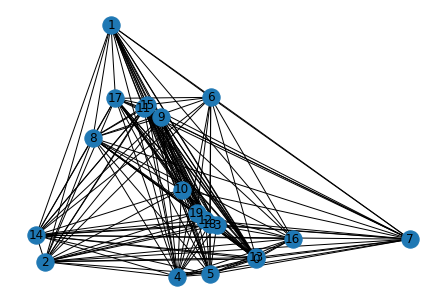

In [10]:
np.random.seed(3)
G = nx.from_numpy_matrix(adj)
labels={i: labels[i] for i in G.nodes}
#G=nx.relabel_nodes(G, labels)
pos= nx.draw_spring(G,with_labels=True)

plt.axis("off")
plt.show()

In [11]:
bb = nx.betweenness_centrality(G)
cc = nx.closeness_centrality(G)
dc = nx.degree_centrality(G)
centrality = {j:{'betweenness':bb[j],'closeness': cc[j],'degree': dc[j]} for i,j in enumerate(G.nodes)}
nx.set_node_attributes(G, centrality)



dict(sorted(bb.items(), key=lambda item: -item[1]))

{1: 0.006907609074791737,
 2: 0.006907609074791737,
 4: 0.006907609074791737,
 5: 0.006907609074791737,
 8: 0.006907609074791737,
 13: 0.006907609074791737,
 14: 0.006907609074791737,
 15: 0.006907609074791737,
 18: 0.006907609074791737,
 19: 0.006031979716190243,
 0: 0.004021119346196746,
 17: 0.0032304869766170076,
 7: 0.0028864897285949915,
 6: 0.0013629587932993505,
 16: 0.000449842555105713,
 3: 0.0003439972480220158,
 9: 0.0003439972480220158,
 10: 0.0003439972480220158,
 11: 0.0003439972480220158,
 12: 0.0003439972480220158}

In [16]:
summary=pd.DataFrame({'betweenness':bb, 'closeness':cc, 'degree':dc}).reset_index()

In [17]:
summary['index']=labels

In [18]:
summary

,index,betweenness,closeness,degree
0,pictet north america advisors sa,0.004021,0.950000,1.052632
1,barings llc,0.006908,1.000000,1.105263
2,ubs group ag,0.006908,1.000000,1.105263
3,pictet bank & trust ltd,0.000344,0.904762,1.000000
4,banque pictet & cie sa,0.006908,1.000000,1.105263
5,pictet & cie (europe) sa,0.006908,1.000000,1.105263
6,"aegon usa investment management, llc",0.001363,0.760000,0.789474
7,"transamerica financial advisors, inc.",0.002886,0.904762,1.000000
8,invesco ltd.,0.006908,1.000000,1.105263
9,oaktree capital management lp,0.000344,0.904762,1.000000


community detection

In [19]:
#Label propagation algorithm
from networkx.algorithms.community.label_propagation import label_propagation_communities
I=list(label_propagation_communities(G))
#no parameters to tune
I #no communities detected

[{0},
 {1},
 {2},
 {3},
 {4},
 {5},
 {6},
 {7},
 {8},
 {9},
 {10},
 {11},
 {12},
 {13},
 {14},
 {15},
 {16},
 {17},
 {18},
 {19}]

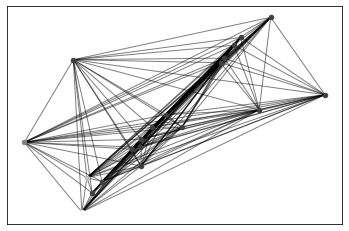

In [20]:
import community
#louvain method if i understand correctly #from this website https://perso.crans.org/aynaud/communities/
#first compute the best partition
partition = community.best_partition(G)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(G,pos, alpha=0.5)
plt.show()

In [21]:
#another algorithm for community detection
def edge_to_remove(graph):
    G_dict=nx.edge_betweenness_centrality(graph)
    edge=()
    
    #extract the edge with the highest edge betweenness centrality score
    for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse=True):
        edge=key
        break
    return edge
def girvan_newman(graph):
	# find number of connected components
	sg = nx.connected_components(graph)
	sg_count = nx.number_connected_components(graph)

	while(sg_count == 1):
		graph.remove_edge(edge_to_remove(graph)[0], edge_to_remove(graph)[1])
		sg = nx.connected_components(graph)
		sg_count = nx.number_connected_components(graph)

	return sg

In [22]:
#find communities in the graph
c=girvan_newman(G.copy())
#find the nodes forming the communities
node_groups=[]

for i in c:
    node_groups.append(list(i))

In [23]:
node_groups

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19], [16]]

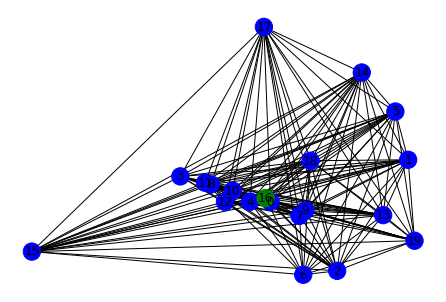

In [24]:
# plot the communities
color_map = []
for node in G:
    if node in node_groups[0]:
        color_map.append('blue')
    else: 
        color_map.append('green')  

nx.draw(G, node_color=color_map, with_labels=True)
plt.show()

In [25]:
nx.all_pairs_node_connectivity(G)
#no parameters to tune

{0: {1: 18,
  2: 18,
  3: 17,
  4: 18,
  5: 18,
  6: 13,
  7: 17,
  8: 18,
  9: 17,
  10: 17,
  11: 17,
  12: 17,
  13: 18,
  14: 18,
  15: 18,
  16: 12,
  17: 18,
  18: 18,
  19: 18},
 1: {0: 18,
  2: 19,
  3: 17,
  4: 19,
  5: 19,
  6: 13,
  7: 17,
  8: 19,
  9: 17,
  10: 17,
  11: 17,
  12: 17,
  13: 19,
  14: 19,
  15: 19,
  16: 12,
  17: 18,
  18: 19,
  19: 18},
 2: {0: 18,
  1: 19,
  3: 17,
  4: 19,
  5: 19,
  6: 13,
  7: 17,
  8: 19,
  9: 17,
  10: 17,
  11: 17,
  12: 17,
  13: 19,
  14: 19,
  15: 19,
  16: 12,
  17: 18,
  18: 19,
  19: 18},
 3: {0: 17,
  1: 17,
  2: 17,
  4: 17,
  5: 17,
  6: 13,
  7: 17,
  8: 17,
  9: 17,
  10: 17,
  11: 17,
  12: 17,
  13: 17,
  14: 17,
  15: 17,
  16: 12,
  17: 17,
  18: 17,
  19: 17},
 4: {0: 18,
  1: 19,
  2: 19,
  3: 17,
  5: 19,
  6: 13,
  7: 17,
  8: 19,
  9: 17,
  10: 17,
  11: 17,
  12: 17,
  13: 19,
  14: 19,
  15: 19,
  16: 12,
  17: 18,
  18: 19,
  19: 18},
 5: {0: 18,
  1: 19,
  2: 19,
  3: 17,
  4: 19,
  6: 13,
  7: 17,
  8: 19,


In [26]:
nx.node_connectivity(G) #equal to the minimum number of nodes that must be removed to disconnect G or render it trivial
#no parameters to tune

12

In [27]:
nx.degree_assortativity_coefficient(G) #measures the similarity of connections in the graph wrt the nodes 
#maybe we can use the weight parameters

-0.06742658804501575

In [28]:
nx.communicability_betweenness_centrality(G)
#no parameters to tune

{0: 0.6011580100106061,
 1: 0.632787828416763,
 2: 0.632787828416763,
 3: 0.5704573318308696,
 4: 0.6327878284167633,
 5: 0.6327878284167633,
 6: 0.37623727380442146,
 7: 0.5605224841052444,
 8: 0.6327878284167632,
 9: 0.5704573318308703,
 10: 0.5704573318308704,
 11: 0.5704573318308703,
 12: 0.5704573318308704,
 13: 0.6327878284167641,
 14: 0.6327878284167641,
 15: 0.6327878284167641,
 16: 0.33361925732718745,
 17: 0.6029924336146286,
 18: 0.6327878284167643,
 19: 0.5929316250432864}

In [29]:
nx.voterank(G) 
#no parameters to tune

[1, 2, 4, 5, 8, 13, 14, 15, 18, 0, 17, 19]

In [30]:
nx.clustering(G)
#no parameters to tune, but can add the weight for the edge

{0: 0.9477124183006536,
 1: 0.9181286549707602,
 2: 0.9181286549707602,
 3: 0.9926470588235294,
 4: 0.9181286549707602,
 5: 0.9181286549707602,
 6: 0.9615384615384616,
 7: 0.9558823529411765,
 8: 0.9181286549707602,
 9: 0.9926470588235294,
 10: 0.9926470588235294,
 11: 0.9926470588235294,
 12: 0.9926470588235294,
 13: 0.9181286549707602,
 14: 0.9181286549707602,
 15: 0.9181286549707602,
 16: 0.9848484848484849,
 17: 0.954248366013072,
 18: 0.9181286549707602,
 19: 0.9215686274509803}

In [31]:
#jaccard coefficient, calculated by number of common neighbors normalized by total number of neighbors. Measure similarity between two finite sample sets
preds = nx.jaccard_coefficient(G)
#no parameters to tune

In [32]:
for u,v,p in preds:
    print(f"({u}, {v}) -> {p:.8f}")

(0, 6) -> 0.65000000
(3, 16) -> 0.55000000
(3, 6) -> 0.60000000
(6, 9) -> 0.60000000
(6, 10) -> 0.60000000
(6, 11) -> 0.60000000
(6, 12) -> 0.60000000
(7, 16) -> 0.55000000
(7, 19) -> 0.85000000
(9, 16) -> 0.55000000
(10, 16) -> 0.55000000
(11, 16) -> 0.55000000
(12, 16) -> 0.55000000
(16, 17) -> 0.60000000
